# Analysis (draft)

This notebook contains the Python script that analyses the data extracted from the STRESS review.

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional

# use gglot style for all matplotlib
plt.style.use("ggplot")

## 2. Constants

In [2]:
REVIEW_CSV_FILE_PATH = "PY_STRESS.csv"

## 3. Read in review data

> Note this data collected in Excel.

> **TM query (1)**: can we drop column index 27? This is labelled 27 and is all values are null.

> **TM query (2)**: there were three blank lines at the end of the CSV. I've removed this in the updated load routine.

> **TM query (3)**: what does DP mean in "used?"

> **TM query (4)**: target authors: is this a manual field you have included? or did you have a formula in Excel? It appears to be different from your calculation at the end?

### 3.1 Data cleaning functions

Smaller function used by the main pipeline to load the dataset.

In [3]:
def recode_whitespace(df: pd.DataFrame) -> pd.DataFrame:
    # strip leading and lagging white space
    df.columns = df.columns.str.strip()
    # replace remaining whitespace with "_"
    df.columns = df.columns.str.replace(" ", "_")
    return df

In [4]:
def strip_punctuation(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = df.columns.str.replace("?", "")
    df.columns = df.columns.str.replace("'", "")
    df.columns = df.columns.str.replace("-", "_")
    df.columns = df.columns.str.replace("/", "")
    return df

In [5]:
def cols_to_lower(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert all column names in a dataframe to lower case

    Params:
    ------
    df - pandas.DataFrame

    Returns:
    -------
    out: pandas.DataFrame
    """
    new_cols = [c.lower() for c in df.columns]
    df.columns = new_cols
    return df

### 3.2 Load Data Pipeline 

In [28]:
def load_review_dataset(
    path: Optional[str] = REVIEW_CSV_FILE_PATH,
) -> pd.DataFrame:
    """Read full data extraction data set for the review from a CSV file.
    Returns cleaned dataset.

    Assumes data is stored in .csv

    Cleaning pipeline for dataset:
    1. drop redunance columns
    2. drop rows that contain all NAs
    3. rename columns with complex strings
    4. strip all punctuation from column headers
    5. column headers to lower case
    6. replace all whitespace in headers with "_"
    7. convert all blank strings in cells to NaN
    8. recode variables to be internally consistent in naming
    9. perform type conversion for integer fields
    10. type conversion for categorical fields

    Parameters:
    ----------
    path: str, optional (default=REVIEW_CSV_FILE_PATH)
        path or URL for review dataset.

    Returns:
    --------
    out: pd.DataFrame

    """

    # SETUP FOR DATASET CLEAN

    # cols to drop from data read in
    cols_to_remove = [
        "Unnamed: 0",
        "...27",
        "Questions to be asked from authors / experts",
        "Fatemeh's Note",
        "Note",
    ]

    # simple type conversions
    type_conversions = {"year": "UInt16"}

    # renaming of columns to names suitable for analysis
    new_labels = {
        "1. Objectives (purpose, model outputs, aims of experimentation)": "stress_objectives",
        "2. Logic (base model overview diagram, base model logic, scenario logic, algorithms, components)": "stress_logic",
        "3. Data (data sources, input parameters, preprocessing, assumptions": "stress_logic",
        "4. Experimentation (initialisation, run length, estimation approach)": "stress_exp",
        "5. Implementation (software and programming language, random sampling, model execution, system specification)": "stress_imp",
        "6. Code access (computer model sharing statement)": "stress_code",
    }

    # used to recode variables so they are consistent.
    recoded_variables = {"used": {"NO": "No"}}

    # DATA CLEANING PIPELINE
    df = (
        pd.read_csv(path, index_col="No")
        # drop redundant index column
        .drop(labels=cols_to_remove, axis=1)
        # drop all blank rows (this will remove the blank 3 rows at end of CSV)
        .dropna(how="all")
        # rename verbose column headers
        .rename(columns=new_labels)
        # remove any punctutation i.e. "?" and "-"
        .pipe(strip_punctuation)
        # all columns headers to lower case
        .pipe(cols_to_lower)
        # replace all whitespace with "_" in col headers
        .pipe(recode_whitespace)
        # replace all whitespace and blank strings in fields with NaN
        .replace(r"^\s*$", np.nan, regex=True)
        # recoded variables e.g. used "NO" becomes "No"
        .replace(recoded_variables)
        # update the type of columns to int where needed
        .astype(type_conversions)
        # categorical variables
        .assign(
            used=lambda x: pd.Categorical(x["used"]),
            type_of_paper=lambda x: pd.Categorical(x["type_of_paper"]),
            partially=lambda x: pd.Categorical(x["partially"]),
            method=lambda x: pd.Categorical(x["method"]),
            software=lambda x: pd.Categorical(x["software"]),
            source_code_access=lambda x: pd.Categorical(
                x["source_code_access"]
            ),
            application_area=lambda x: pd.Categorical(x["application_area"]),
            target_authors=lambda x: pd.Categorical(x["target_authors"]),
            stress_implementation=lambda x: pd.Categorical(
                x["stress_implementation"]
            ),
            hybridisation=lambda x: pd.Categorical(x["hybridisation"])
        )
    )
    return df

In [29]:
# read in data.
clean_review_df = load_review_dataset()

# quick summary of columns
clean_review_df.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
Index: 171 entries, 1 to 171
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   publication            171 non-null    object  
 1   authors                171 non-null    object  
 2   year                   169 non-null    UInt16  
 3   type_of_paper          165 non-null    category
 4   journal                162 non-null    object  
 5   name_of_univerity      73 non-null     object  
 6   type_of_study          166 non-null    object  
 7   pre_prints             171 non-null    object  
 8   doi                    164 non-null    object  
 9   used                   162 non-null    category
 10  partially              71 non-null     category
 11  target_authors         74 non-null     category
 12  method                 74 non-null     category
 13  hybridisation          7 non-null      category
 14  stress_objectives      71 non-null     object  

In [30]:
clean_review_df["hybridisation"].value_counts()

hybridisation
DES+ABS                           3
SD + ABS                          2
DES + SD + ABS                    1
Monte Carlo + Machine learning    1
Name: count, dtype: int64

In [9]:
# rows and columns n's
clean_review_df.shape

(171, 25)

## 3. Filter to empirical studies only 

Here we separate the studies that have used the STRESS guidelines in second dataframe i.e. limit to studies that have used STRESS for documenting a model. This is stored in a notebook level variable called `USED_STRESS`

> Filtering is done using the 'used' field.

In [10]:
def filter_to_application_studies(clean_df: pd.DataFrame) -> pd.DataFrame:
    """Filter the cleaned dataset down to studies that used stress to report
    a simulation study.

    # To do: drop "fatemets_notes", "questions..."
    """
    # Used?: a Yes/No variable.
    return clean_df[clean_df["used"] == "Yes"]

In [11]:
USED_STRESS = filter_to_application_studies(clean_review_df)

In [12]:
# number of studies that used STRESS as intended i.e. to document
USED_STRESS.shape

(73, 25)

In [13]:
USED_STRESS.count()

publication              73
authors                  73
year                     73
type_of_paper            73
journal                  72
name_of_univerity        73
type_of_study            73
pre_prints               73
doi                      73
used                     73
partially                70
target_authors           73
method                   72
hybridisation             7
stress_objectives        70
stress_logic             70
stress_logic             70
stress_exp               70
stress_imp               70
stress_code              70
source_code_access       40
software                 69
application_area         73
case_study               72
stress_implementation    70
dtype: int64

## Simulation software or coding language

What simulation software or coding language was used for the modelling?


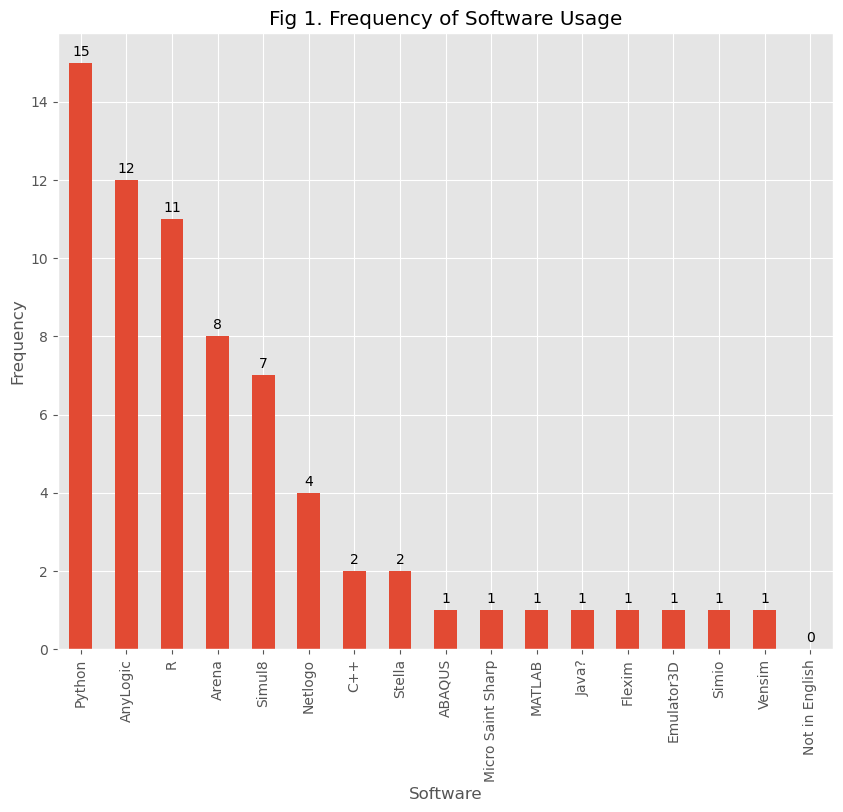

In [14]:
software_freq = USED_STRESS["software"].value_counts()

plt.figure(figsize=(10, 8))
sb = software_freq.plot(kind="bar")

plt.title("Fig 1. Frequency of Software Usage")
plt.xlabel("Software")
plt.ylabel("Frequency")

sb.bar_label(sb.containers[0], label_type="edge", padding=3)


plt.show()

## Simulation method 

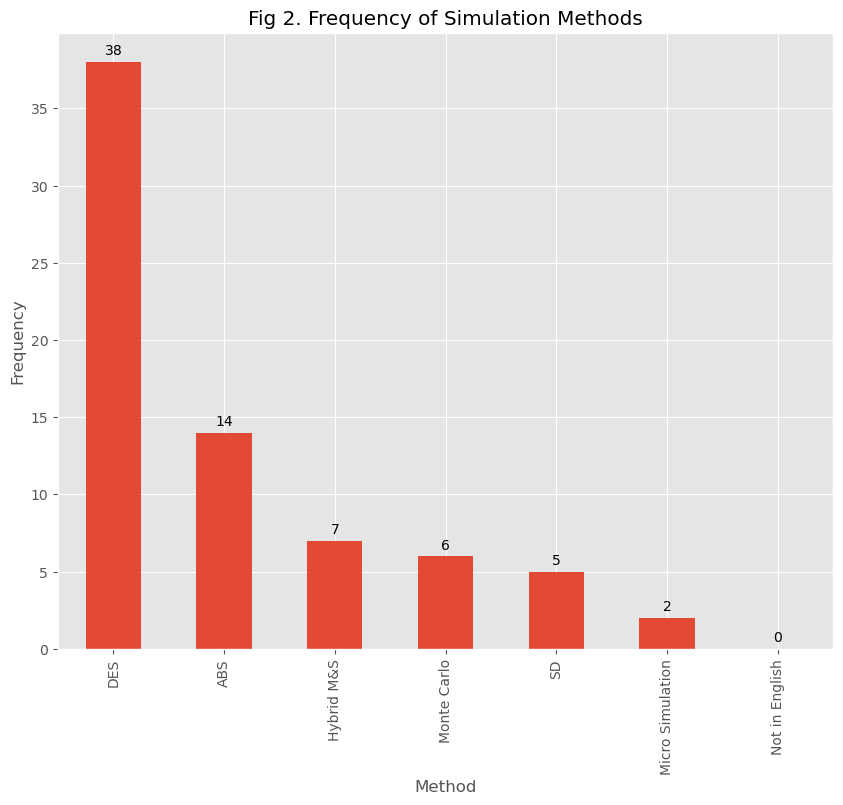

In [15]:
## Hybrid M&S could be the hybridisation of simulation methods (e.g. SD+DES)
## or hybridisation of a simulation method with data science approach (e.g.
## Monte Carlo simulation + Machine learning)

Method_freq = USED_STRESS["method"].value_counts()

plt.figure(figsize=(10, 8))
MB = Method_freq.plot(kind="bar")

plt.title("Fig 2. Frequency of Simulation Methods")
plt.xlabel("Method")
plt.ylabel("Frequency")
# Add data labels on the bars
MB.bar_label(MB.containers[0], label_type="edge", padding=3)

plt.show()

## Year of publication

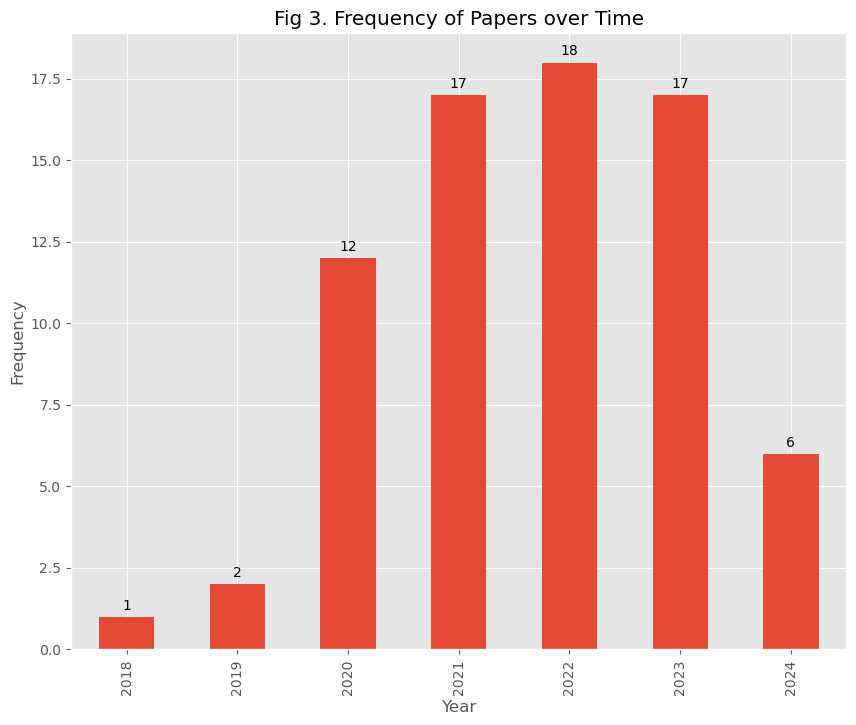

In [16]:
## The frequency of papers that have used STRESS guidelines based on the publication year
Year_freq = USED_STRESS["year"].value_counts().sort_index(ascending=True)

plt.figure(figsize=(10, 8))
YB = Year_freq.plot(kind="bar")

plt.title("Fig 3. Frequency of Papers over Time")
plt.xlabel("Year")
plt.ylabel("Frequency")

# Add data labels on the bars
YB.bar_label(YB.containers[0], label_type="edge", padding=3)

plt.show()

## Application area

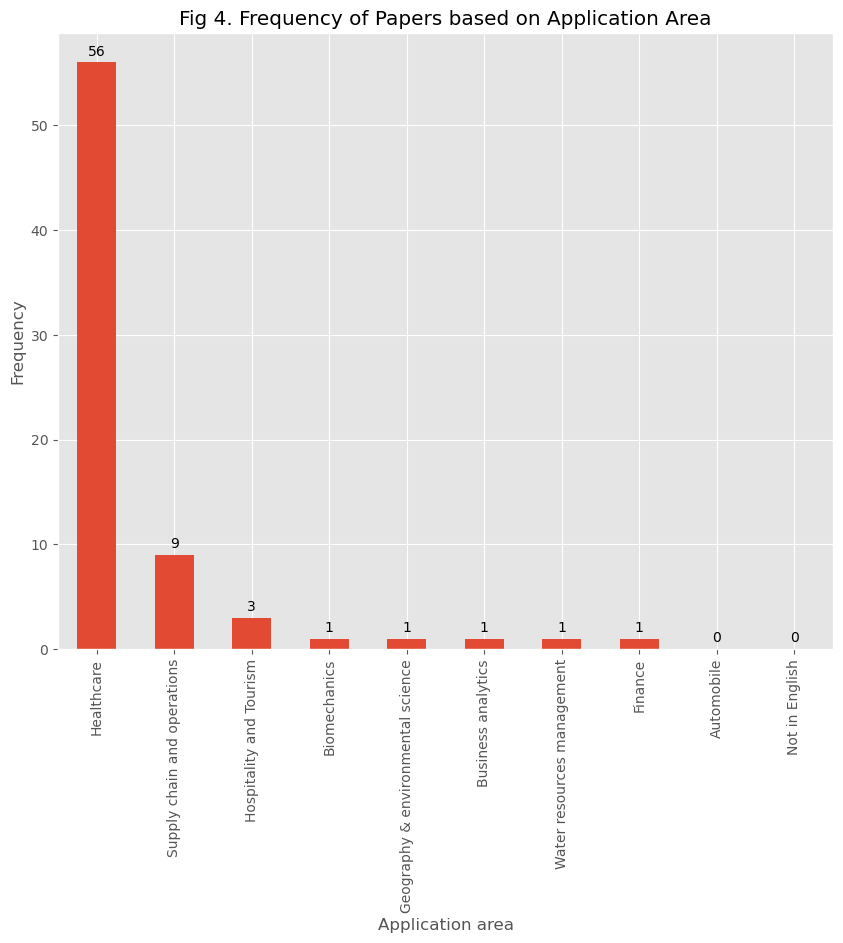

In [17]:
APP_freq = USED_STRESS["application_area"].value_counts()

plt.figure(figsize=(10, 8))
APB = APP_freq.plot(kind="bar")

plt.title("Fig 4. Frequency of Papers based on Application Area")
plt.xlabel("Application area")
plt.ylabel("Frequency")

# Add data labels on the bars
APB.bar_label(APB.containers[0], label_type="edge", padding=3)

plt.show()

# Article Type

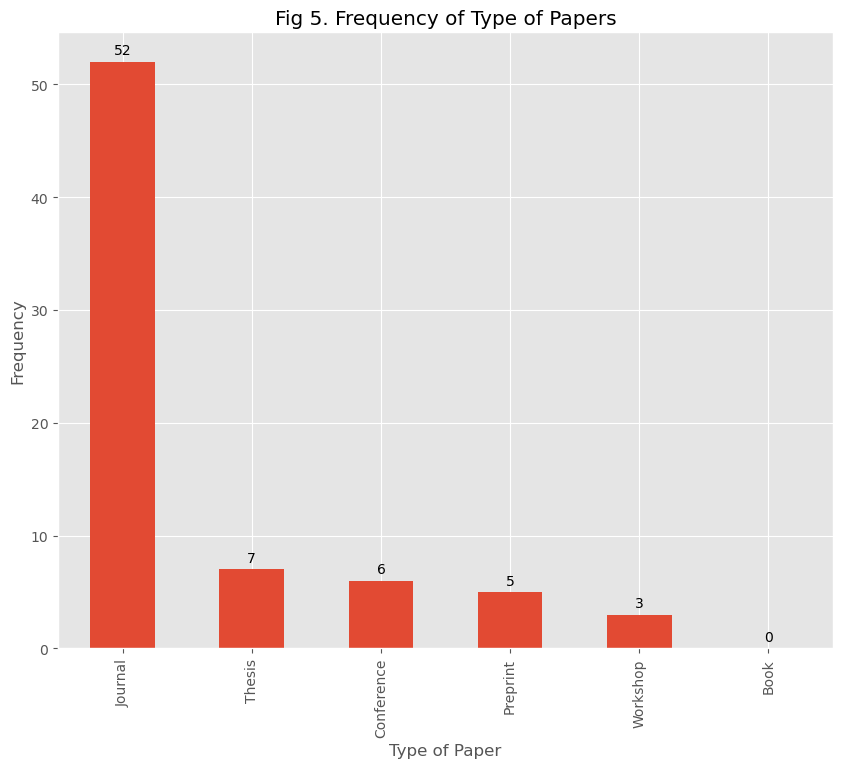

In [18]:
## Type of papers that have used STRESS; which includes journal, conference,
## workshop, and preprints papers as well as thesis.

Paper_Type_freq = USED_STRESS["type_of_paper"].value_counts()

plt.figure(figsize=(10, 8))
PTB = Paper_Type_freq.plot(kind="bar")

plt.title("Fig 5. Frequency of Type of Papers")
plt.xlabel("Type of Paper")
plt.ylabel("Frequency")

# Add data labels on the bars
PTB.bar_label(PTB.containers[0], label_type="edge", padding=3)

plt.show()

## Usage by Journal/conference/other

> **TM query**: Computational Management Science appears twice? small different in raw data recording?

In [19]:
Journal_freq = USED_STRESS["journal"].value_counts()

Journal_freq = Journal_freq.reset_index()
Journal_freq.columns = ["Journal", "Frequency"]

Journal_freq.set_index(["Journal"], inplace=True)

# Print the resulting DataFrame
Journal_freq

,Frequency
Journal,
Journal of Simulation,11
Winter Simulation Conference,6
BMJ,4
Proceedings of the Operational Research Society Simulation Workshop,3
University of Southampton,3
Operations Research for Health Care,3
Lancaster University,2
Health Care Management Science,2
Plos one,2


## Full versus partial usage of STRESS sections

> TM note - we should provide %'s as well as counts

In [20]:
Partially_freq = USED_STRESS["partially"].value_counts()

Partially_freq = Partially_freq.reset_index()
Partially_freq.columns = ["Partially?", "Frequency"]

# Print the resulting DataFrame
print(Partially_freq)

  Partially?  Frequency
0        Yes         45
1         No         25
2         DP          0


## How was STRESS used?

The guideline have been listed either in main text, or in appendix. Also it might be in the form of checklist, structured (that contains the guidelines' elements with  description), and unstructured (which might contain some elements of the guideline).

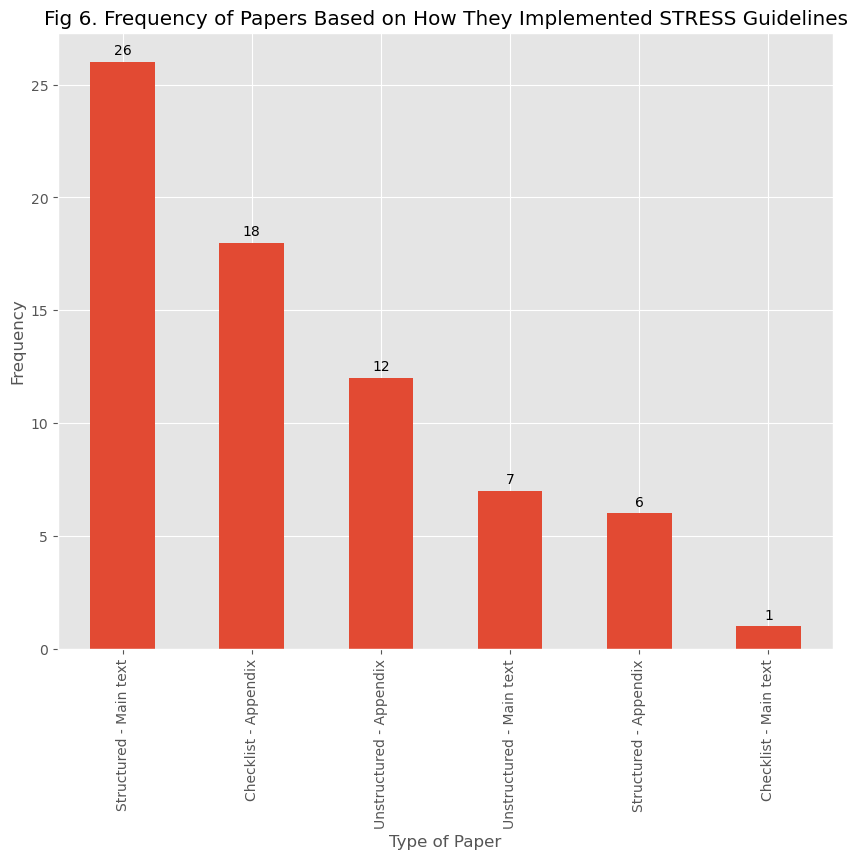

In [21]:
Checklist_freq = USED_STRESS["stress_implementation"].value_counts()

plt.figure(figsize=(10, 8))
CAB = Checklist_freq.plot(kind="bar")

plt.title(
    "Fig 6. Frequency of Papers Based on How They Implemented STRESS Guidelines"
)
plt.xlabel("Type of Paper")
plt.ylabel("Frequency")

# Add data labels on the bars
CAB.bar_label(CAB.containers[0], label_type="edge", padding=3)

plt.show()

## Is the coded model available?

> TM note: cannot be shared for confidential reasons = "No"


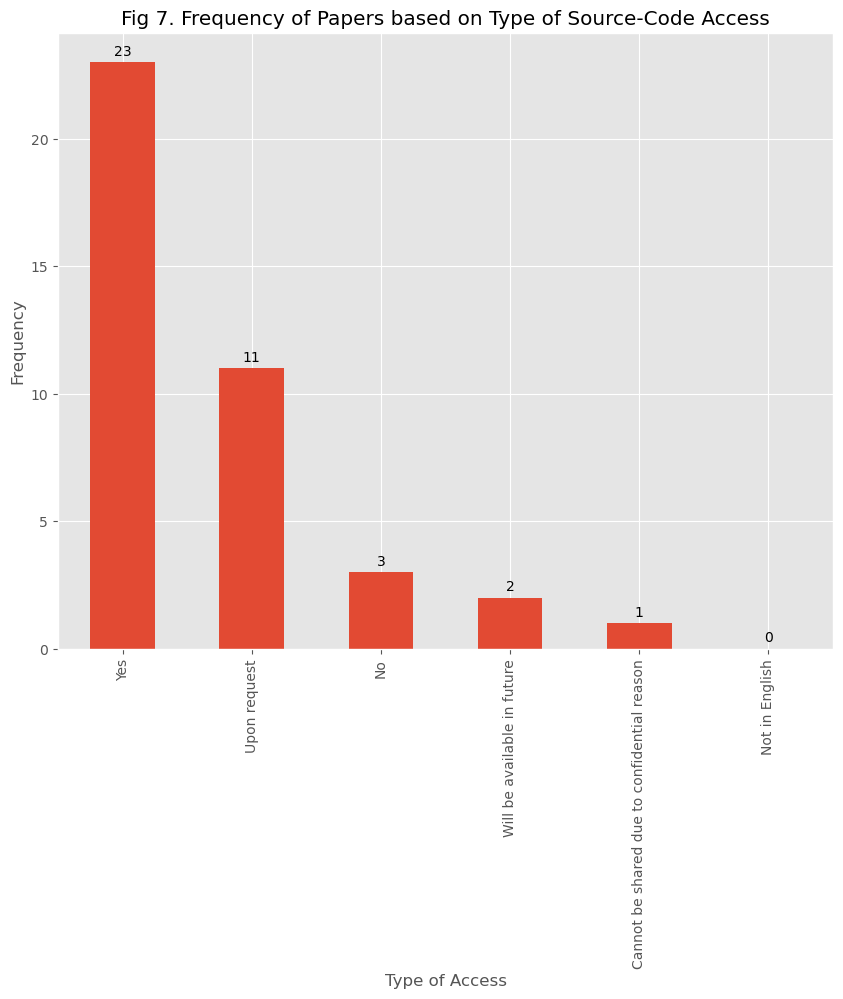

In [22]:
Code_Access_freq = USED_STRESS["source_code_access"].value_counts()

plt.figure(figsize=(10, 8))
SCAB = Code_Access_freq.plot(kind="bar")

plt.title("Fig 7. Frequency of Papers based on Type of Source-Code Access")
plt.xlabel("Type of Access")
plt.ylabel("Frequency")

# Add data labels on the bars
SCAB.bar_label(SCAB.containers[0], label_type="edge", padding=3)

plt.show()

# How many of the publications contain at least one author from STRESS 1.0?

> TM note - the no target author list seems wrong!

In [23]:
target_authors = ["Monks", "Currie", "Onggo", "Robinson", "Kunc", "Taylor"]

In [24]:
USED_STRESS["authors"] = USED_STRESS["authors"].astype(str)

/tmp/ipykernel_112084/3409471218.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  USED_STRESS["authors"] = USED_STRESS["authors"].astype(str)


In [25]:
def split_publications_by_stress_authors(target_authors):
    """of
    Returns two dataframes.  One contains all publications where at least one
    of the authors was a member of the original stress team.  The second
    excludes all stress team members.
    """

    target_included = []
    not_target_authors = []

    for index, row in USED_STRESS.iterrows():
        authors_in_row = row["authors"]

        # Check for missing or NaN values
        if pd.isna(authors_in_row):
            not_target_authors.append(
                None
            )  # If it's NaN, consider as not_target_authors
            continue

        authors_in_row = authors_in_row.split(
            ", "
        )  # Assuming author names are separated by ', '

        for authors in authors_in_row:
            if any(
                target_authors in authors for target_authors in target_authors
            ):
                target_included.append(
                    row
                )  # Append the entire row's authors to the target_included list

            else:
                not_target_authors.append(
                    row
                )  # Append the entire row's authors to the not_target_authors list

    df_target_included = pd.DataFrame(target_included, columns=["authors"])
    df_not_target_authors = pd.DataFrame(
        not_target_authors, columns=["authors"]
    )
    return df_target_included, df_not_target_authors

In [26]:
df_target_included, df_not_target_authors = (
    split_publications_by_stress_authors(target_authors)
)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
# Display the DataFrames
print(
    f"Papers including at least one STRESS author: n = {len(df_target_included)}"
)

In [ ]:
print(f"Papers with no STRESS authors n = {len(df_not_target_authors)}")